# **CircuitQuest**
This colab details the SynE model, which is one of the two model proposed in the CircuitQuest project.

I will likely continue the project in the future. If you would like to collobrate, reach out at mhubb@stanford.edu. If you need access to the databucket to run the code in this Colab, also reach out. I cannot promise I will host the code in the cloud forever. We have already granted Kexin the owernship of the bucket.

In [ ]:
#Connect to the Google Databucket hosting the OpenABC dataset and authenticate
!pip install -q gcsfs google-cloud-storage
from google.colab import auth
auth.authenticate_user(clear_output=True)

#install torch and other GNN libs
!pip install -q torch torch-geometric ogb
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install -q torch-scatter -f $scatter_src
!pip install -q torch-sparse -f $sparse_src


from google.cloud import storage
from torch_geometric.data import Data, Dataset, DataLoader
from io import StringIO, BytesIO
from tqdm.auto import tqdm, trange
import re
import os
import csv
import warnings
import gc
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import sys
import torch
import torch.nn as nn
import torch_scatter
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, GINConv
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops, degree
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 44.2 MB/s eta 0:00:00


This dataset uses very large graphs to model particular IPs (>50k Nodes). These graphs are AIG graphs (AND-Inverter graphs) that logicaly represent each IP. The data is hosted in a Google databucket. Because these graphs are very large, they are downloaded as they are needed using lazy-loading.

The goal here is to develop a GNN that takes in the data from a step0 pt file and predicts the number of nodes, area, delay, and longest path of the final synthesized AIG. The image below shows all the information in each pt file. Unfortunately, this picture is slighlty inaccurate. The final labels for each .pt file are not contained in the pt file itself. Instead, they final labels are contained in csv files. The final labels are connected to the data from each pt file during preprocessing.

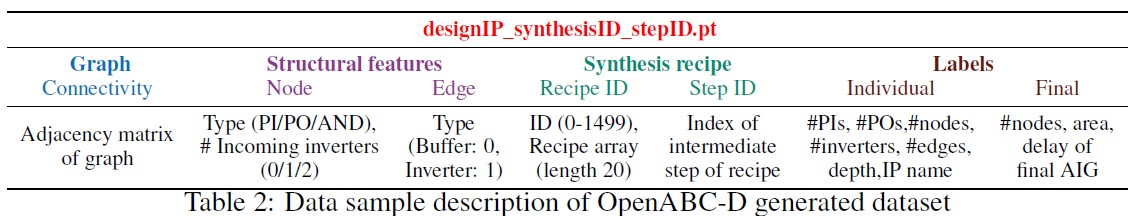

In order to predict the quality metrics of the final graph, we must consider data from two different places. First, we must consider the AIG graph at step 0. This graph represents the IP before any synthesis steps have been conducted. This graph is represented by an edge index list and the structural features of the nodes and edges. Second, we must also consider the synthesis recipe. Using both the graph and the synthesis recipe, we can predict metrics about the final AIG.

Let us consider the AIG graph first. We aim to create a GNN that can create a graph level embedding for an AIG. To do this, we create a node level embedding for each node then apply a pooling method to all the node embeddings in the graph. Importantly, our nodes have complex structural features. They have a node type (PI/Po/AND) [0,1,2] and a number of incoming inverters [0,1,2]. This information must be encoded into an intial embedding for each node. This is encoder is developed below.


In [ ]:
#create Node encoder
class NodeEncoder(torch.nn.Module):
    def __init__(self, num_node_types, num_node_inputs, output_dim):
      assert(output_dim % 2 == 0), "Output dim of the Node Encoder must be even"
      o_dim = output_dim // 2
      super(NodeEncoder, self).__init__()
      #create node type encoder
      self.node_type_embedding = torch.nn.Embedding(num_node_types, o_dim)
      #initilize encoder weights
      torch.nn.init.xavier_uniform_(self.node_type_embedding.weight.data)
      #create in_inverter encoder
      self.num_in_inverters_embedding = torch.nn.Embedding(num_node_inputs, o_dim)
      #initialize encoder weights
      torch.nn.init.xavier_uniform_(self.num_in_inverters_embedding.weight.data)

    # x is an input matrix of shape [batchSize, 2] where column 0 is the node type and column 1 is the num_in_inverters
    def forward(self, x):
      #create node type embedding
      assert(x.shape[1] == 2), "Input matrix must have shape [batchSize, 2]"
      # print(x.device)
      node_type_embedding = self.node_type_embedding(x[:,0])
      #create in_inverters embedding
      num_in_inverters_embedding = self.num_in_inverters_embedding(x[:,1])
      #concatenate embeddings and return
      return torch.cat((node_type_embedding, num_in_inverters_embedding), dim=1)


The Encoder above takes in the features of a node, and converts it to an embedding of size output_dim. This output serves as the initial feature vector for a GNN that develops node embeddings. Next, we must create the GNN that generates the node level embeddings for each node through messsage passing. We aim to explore multiple different layer types in this project. The code below creates the layer modules for GCN and GraphSage. An off the shelf GIN message passing layer is also used.

In [ ]:
# Create a model that takes in a graph and predicts the number of nodes in the optimized graph
#Create GCNConv layer
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [ ]:
class GraphSage(MessagePassing):
  def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
    super(GraphSage, self).__init__(**kwargs)

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.normalize = normalize

    # self.lin_l is the linear transformation that you apply to embedding for central node.
    # self.lin_r is the linear transformation that you apply to aggregated message from neighbors.
    self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
    self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)
    self.reset_parameters()

  def reset_parameters(self):
    self.lin_l.reset_parameters()
    self.lin_r.reset_parameters()

  def forward(self, x, edge_index, size = None):
    info = self.propagate(edge_index,x=(x, x), size=size)
    prop_post = self.lin_r(info)
    curr_post = self.lin_l(x)
    out = prop_post + curr_post
    if self.normalize:
        out = torch.nn.functional.normalize(out, p=2)
    return out

  def message(self, x_j):
    out = x_j
    return out

  def aggregate(self, inputs, index, dim_size = None):
    # The axis along which to index number of nodes.
    node_dim = self.node_dim
    out = torch_scatter.scatter(inputs, index, dim = node_dim, dim_size = dim_size, reduce="mean")

    return out


With layer modules defined, we can now define a GNN to embed nodes.

In [ ]:
class Node_GNN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, args):
    super(Node_GNN, self).__init__()

    self.num_layers = num_layers
    self.dropout = args["dropout"]
    self.dropout_val = args["dropout_val"]
    self.final_layer = args["final_layer"]
    self.batch_norm = args["batch_norm"]
    conv_model = self.get_conv_model(args["model_type"])
    self.activation = self.get_activation(args["activation"])

    self.batch_norms = nn.ModuleList() #mod list for batch norms
    self.convs = nn.ModuleList() #mod list for message passing layers
    #create node encoder
    self.node_encoder = NodeEncoder(num_node_types=3, num_node_inputs=3, output_dim=input_dim)

    assert (self.num_layers >= 1), 'Number of layers is not >=1'

    #create module layers of type args["model_type"] (GCNConv, GraphSage, other)
    for l in range(self.num_layers-1):
      if conv_model != GINConv:
        if(l == 0):
          self.convs.append(conv_model(input_dim, hidden_dim))
        else:
          self.convs.append(conv_model(hidden_dim, hidden_dim))
      else: #case where we are using GIN and initialization is very different
        if (l == 0):
          #create mlp for GIN layer
          mlp = torch.nn.Sequential(
              torch.nn.Linear(input_dim, hidden_dim),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_dim, hidden_dim)
          )
          self.convs.append(conv_model(mlp, train_eps=True))
        else:
          mlp = torch.nn.Sequential(
              torch.nn.Linear(hidden_dim, hidden_dim),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_dim, hidden_dim)
          )
          self.convs.append(conv_model(mlp, train_eps=True))
      if self.batch_norm: #follow each message passing layer with a batch norm
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

    #setup final layer based upon final_layer var in args
    if self.final_layer == 0: #final conv layer and batch norm
      if conv_model != GINConv:
        self.convs.append(conv_model(hidden_dim, output_dim))
        self.batch_norms.append(torch.nn.BatchNorm1d(output_dim))
      else:
        mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
        self.convs.append(conv_model(mlp, train_eps=True))
        self.batch_norms.append(torch.nn.BatchNorm1d(output_dim))
    elif self.final_layer == 1: #post message passing MLP layer
      if conv_model == GINConv:
        mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.convs.append(conv_model(mlp, train_eps=True))
      else:
        self.convs.append(conv_model(hidden_dim, hidden_dim))
      self.post_mlp = nn.Sequential(
          nn.Linear(hidden_dim, hidden_dim),
          nn.Dropout(self.dropout),
          nn.Linear(hidden_dim, output_dim)
      )

  def forward(self, data_batch):
    edge_index = data_batch['edge_index']
    x = data_batch['node_inv']
    # send initial node data into the encoder to develop initial node embeddings
    h = self.node_encoder(x)

    #send data through the layers to develop richer embeddings through message passing
    for i in range(self.num_layers - 1):
      h = self.convs[i](h, edge_index)
      if self.batch_norm:
        h = self.batch_norms[i](h)
      h = self.activation(h)
      if self.dropout:
        F.dropout(h,p=self.dropout_val, training=self.training)

    #apply final layer
    if self.final_layer == 0: #no trailing MLP
      h = self.convs[-1](h, edge_index)
      h = self.batch_norms[-1](h)
      return h
    elif self.final_layer == 1: #post MLP layer
      h = self.convs[-1](h, edge_index)
      h = self.post_mlp(h)
      return h

  def get_conv_model(self, model_type):
    if model_type == 'GCN':
      return GCNConv
    elif model_type == 'GraphSage':
      return GraphSage
    elif model_type == 'GIN':
      return GINConv
    else:
      raise ValueError('Invalid GNN type')

  def get_activation(self, activation):
    if activation == 'relu':
      return F.relu
    elif activation == 'sigmoid':
      return F.sigmoid
    elif activation == 'tanh':
      return F.tanh
    else:
      raise ValueError('Invalid activation function')


The code above establishs a GNN capable of developing node embeddings using GCN, GraphSage, or GIN as the layer modules. The module is parameterized and has two different final layers. One ending is another layer module of the defined module type. Another is an MLP. The use of batch norm, dropout, activation function, and the final layer type can be controlled in the args dict.

Next, we must develop a GNN that creates the embedding for an entire graph. This embeddng will use the node level embeddings to compute a graph level embedding. Based upon the GNN_encoding scheme detailed in the args dict, either mean, sum, or max pooling is utilized. Two different pooling aggregation functions are utilized, and the two aggregated embeddings are concatenated together.

In [ ]:
class Graph_GNN(torch.nn.Module):

  def __init__(self, input_dim, hidden_dim, emb_dim, node_num_layers, args):
    super(Graph_GNN, self).__init__()

    self.node_GNN = Node_GNN(input_dim, hidden_dim, emb_dim, node_num_layers, args)
    if args["GNN_encoding"] == "mean-sum":
      self.pool1 = global_mean_pool
      self.pool2 = global_add_pool
    elif args["GNN_encoding"] == "mean-max":
      self.pool1 = global_mean_pool
      self.pool2 = global_max_pool
    elif args["GNN_encoding"] == "sum-max":
      self.pool1 = global_add_pool
      self.pool2 = global_max_pool
    else:
      raise ValueError("Invalid GNN encoding type")

  def forward(self, data_batch):
    h_node = self.node_GNN(data_batch)
    h_graph_1 = self.pool1(h_node, data_batch.batch)
    h_graph_2 = self.pool2(h_node, data_batch.batch)
    h_graph = torch.cat([h_graph_1, h_graph_2],dim=1) #mean then max
    return h_graph

The next order of business is encoding the synthesis recipe. Please reconsider the image below. 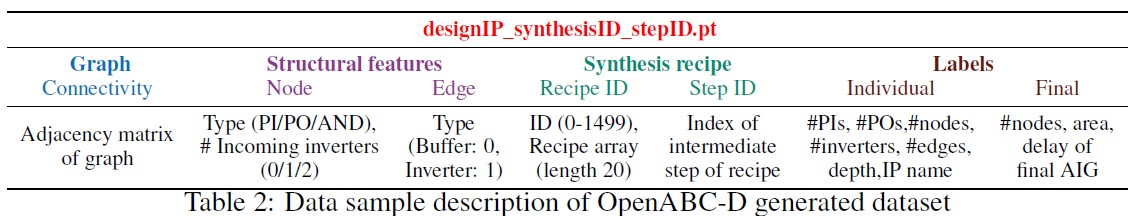

The synthesis recipe information has three components, ID, recipe array, and index. For our learning goals, only the recipe array is important. The recipe ID is only for organizaiton and our model only uses stepID = 0. What is important here is the recipe array. This dimension 20 vector encodes the specific recipe used to develop the final AIG. To add expressivity to the model, the recipe vector is input into a series of linear layers with batch norm. After running through the encoder, each recipe is embedded into an expressive vector.

In [ ]:
class RecipeEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, args):
      super(RecipeEncoder, self).__init__()
      self.num_layers = num_layers
      self.activation = self.get_activation(args["activation"])
      self.dropout_val = args["dropout_val"]
      self.dropout = args["dropout"]
      assert(self.num_layers >= 1), "Num layers in recipe encoder must be >= 1"

      self.linear_layers = nn.ModuleList()
      self.batch_norms = nn.ModuleList()

      #create input layer
      self.linear_layers.append(nn.Linear(input_dim, hidden_dim))
      self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
      #create hidden layers
      for i in range(num_layers-2):
        self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
      #create output layers
      self.linear_layers.append(nn.Linear(hidden_dim, output_dim))
      self.batch_norms.append(nn.BatchNorm1d(output_dim))

    #define the forward pass
    def forward(self, x):
      for i in range(self.num_layers):
        x = self.linear_layers[i](x)
        x = self.batch_norms[i](x)
        x = self.activation(x)
        if self.dropout:
          x = F.dropout(x, self.dropout_val)
      return x

    def get_activation(self, activation):
      if activation == 'relu':
        return F.relu
      elif activation == 'sigmoid':
        return F.sigmoid
      elif activation == 'tanh':
        return F.tanh
      else:
        raise ValueError('Invalid activation function')


Now with a model capable of encoding each AIG and recipe, we can synthesize both models into a final model that predicts the imperative metrics of the final AIG.

The recipe and AIG embeddings are concatenated together to arrive at a final embedding for the AIG, recipe combination.

In [ ]:
class AIG_Recipe_GNN(nn.Module):
    def __init__(self, GNN_layers, GNN_outputs, GNN_hidden_dim, args):
      super(AIG_Recipe_GNN, self).__init__()

      self.num_layers = GNN_layers
      self.activation = self.get_activation(args["activation"])
      self.dropout_val = args["dropout_val"]
      self.dropout = args["dropout"]
      self.node_emb_dim = args["node_emb_dim"]
      self.recipe_emb_dim = args["recipe_emb_dim"]
      assert(self.num_layers >= 1), "Num layers in AIG-Recipe GNN must be >= 1"
      #create graph encoder
      self.graph_encoder = Graph_GNN(input_dim=args["initial_node_dim"], hidden_dim=args["node_hidden_dim"],
                                     emb_dim=args["node_emb_dim"], node_num_layers=args["node_layers"], args=args)
      #create recipe encoder
      self.recipe_encoder = RecipeEncoder(input_dim=20, hidden_dim=args["recipe_hidden_dim"],
                                          output_dim=args["recipe_emb_dim"], num_layers=args["recipe_lin_layers"],
                                          args=args)
      #send the concatenation through some linear layers for predicting the num nodes, area, delay
      self.lin_layers = nn.ModuleList()
      self.batch_norms = nn.ModuleList()

      self.lin_layers.append(nn.Linear(2*self.node_emb_dim + self.recipe_emb_dim, GNN_hidden_dim))
      self.batch_norms.append(nn.BatchNorm1d(GNN_hidden_dim))

      #create linear layers
      for i in range(GNN_layers-2):
        self.lin_layers.append(nn.Linear(GNN_hidden_dim, GNN_hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(GNN_hidden_dim))

      self.lin_layers.append(nn.Linear(GNN_hidden_dim, GNN_outputs))

    def forward(self, batch):
      graph_emb = self.graph_encoder(batch) #apply graph encoder to graph batch
      recipe_emb = self.recipe_encoder(batch["synVec"]) #apply recipe encoder to recipe
      x = torch.cat((graph_emb, recipe_emb), dim=1) #concat graph embed with recipe embed
      for i in range(self.num_layers-1): #send concat through linear layers
        x = self.lin_layers[i](x)
        x = self.batch_norms[i](x)
        x = self.activation(x)
        if self.dropout:
          x = F.dropout(x, self.dropout_val)
      #apply final layer
      x = self.lin_layers[-1](x)
      return x

    def get_activation(self, activation):
      if activation == 'relu':
        return F.relu
      elif activation == 'sigmoid':
        return F.sigmoid
      elif activation == 'tanh':
        return F.tanh
      else:
        raise ValueError('Invalid activation function')

With the entire model define, it is time develop a training function.

In [ ]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = 5e-3
    opt = args["opt"]
    filter_fn = filter(lambda p : p.requires_grad, params)
    if opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args["lr"], weight_decay=weight_decay)
    elif opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args["lr"], momentum=0.95, weight_decay=weight_decay)
    elif opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args["lr"], weight_decay=weight_decay)
    elif opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args["lr"], weight_decay=weight_decay)
    else:
      print(f"Incorrect optimizer value")
      return None
    return optimizer

This model uses a custom, lazy dataset called SynthesisDataset, which will be defined below. custome_collate is imperative to that dataset working correctly.

To evaluate the perfomance fo the model, I use the mean absolute percent error (MAPE), as defined below.

In [ ]:
def custom_collate(batch):
    # Stack the `.nip` attributes along the first dimension
    node_inv_batch = torch.stack([data.node_inv for data in batch])
    synVec_batch = torch.stack([data.synVec for data in batch])
    y_batch = torch.stack([data.y for data in batch])
    edge_batch = torch.stack([data.edge_index for data in batch])
    # Return the full batch of data objects, with `.nip` stacked
    return {
        'node_inv': node_inv_batch,
        'synVec': synVec_batch,
        'y': y_batch,
        'edge_index': edge_batch
    }

#create function to create human interpretable loss function
#mean absolue percentage error
def mape(y_pred, y_true, epsilon=1e-8):
  y_true += epsilon
  per_error = torch.abs((y_true - y_pred) / y_true)
  return torch.mean(per_error, dim=0) * 100

Now, with the model completely defined, we can develop the training loop.

In [ ]:
#develop training function
import time
def train_and_test(dataset, y_scale, error_fn, args, return_model=False):
  #create train and test datasets and dataloaders
  mape = error_fn
  num_data = len(dataset)
  train_num = int(num_data * args["per_train"])
  val_num = int(num_data * (args["per_val"]+args["per_train"]))

  train_dataset = dataset[:train_num]
  val_dataset = dataset[train_num:val_num]
  test_dataset = dataset[val_num:]

  train_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True, collate_fn=custom_collate)
  val_loader = DataLoader(val_dataset, batch_size=args["batch_size"], shuffle=False, collate_fn=custom_collate)
  test_loader = DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=False, collate_fn=custom_collate)

  #create model
  model = AIG_Recipe_GNN(
    GNN_layers=args["GNN_layers"],
    GNN_outputs=args["GNN_outputs"],
    GNN_hidden_dim=args["GNN_hidden_dim"],
    args = args
  )
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  #build optimizer
  opt  = build_optimizer(args, model.parameters())
  scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
  loss_fn = nn.MSELoss()

  #train
  losses = []
  val_losses = []
  train_mapes = None
  val_mapes = None
  start_time = time.time()

  for epoch in trange(args["epochs"], desc="Training", unit="Epochs"):
    model.train()
    total_loss = 0
    total_mape = 0
    with tqdm(train_loader, desc="  Training", unit="Batch", leave=False) as batch_bar:
      for batch in batch_bar:
        opt.zero_grad()
        pred = model(batch)
        #calculate mape
        err = mape(pred * y_scale, batch['y'])
        total_mape += err.detach().cpu().numpy() * args["batch_size"]
        loss = loss_fn(pred, batch['y']/y_scale)
        loss.backward()
        opt.step()
        #cal losses
        total_loss += loss.item() * batch.num_graphs
    #calc total losses and MAPEs
    total_loss /= len(train_loader.dataset)
    total_mape /= len(train_loader.dataset)
    train_mapes = total_mape if train_mapes is None else np.vstack((train_mapes, total_mape))
    losses.append(total_loss)

    #validate every so many epochs
    if epoch % args["val_amount"]== 0:
      model.eval()
      val_loss = 0
      val_mape = 0
      with torch.no_grad():
        with tqdm(val_loader, desc="Validation", unit="Batch", leave=False) as val_bar:
          for batch in val_bar:
            pred = model(batch)
            #calc losses
            loss = loss_fn(pred, batch['y']/y_scale)
            val_loss += loss.item() * batch.num_graphs
            err = mape(pred * y_scale, batch['y'])
            val_mape += err.cpu().numpy() * args["batch_size"]
        #calc total loss
        val_loss /= len(val_loader.dataset)
        val_mape /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_mapes = val_mape if val_mapes is None else np.vstack((val_mapes, val_mape))
      print(f"Epoch: {epoch}, Validation Loss: {val_loss}")
      print(f"Epoch: {epoch}, Validation MAPE: {val_mape}")

    scheduler.step()

  #after training has completed, now test
  test_loss = 0
  test_mape = 0
  for batch in tqdm(test_loader, desc="Testing", unit="Batch"):
    model.eval()
    with torch.no_grad():
      pred = model(batch)
      loss = loss_fn(pred, batch['y']/y_scale)
      test_loss += loss.item() * batch.num_graphs
      #calculate test mape
      err = mape(pred * y_scale, batch['y'])
      test_mape += err.cpu().numpy() * args["batch_size"]
  test_loss /= len(test_loader.dataset)
  test_mape /= len(test_loader.dataset)
  print(f"Test Loss: {test_loss}")
  print(f"Test MAPE: {test_mape}")
  if return_model:
    return  losses, val_losses, train_mapes, val_mapes, test_loss, test_mape, model
  else:
    return losses, val_losses, train_mapes, val_mapes, test_loss, test_mape


With the training function defined, we are almost ready to train the model. First, we must preprocess the data. This is a particularly complicated method. .pt files are fetched from the Google databucket and downloaded to the host machine. A list of the file paths for the downloaded .pt files are supplied to a lazy dataset. When the dataloader requests data for training, the dataset loads the appropriate .pt files, fetches the relavant AIG information, fetches the correspond final AIG metrics, and returns a new data object only with the information needed by the model. This process is detailed in the code below.

In [ ]:
#instead of downloading the .pt files during training, I will download all the pt files for a particular ip first, then I'll create the Data
#objects as they are called during training
def get_file_names_new(bucket_name, directory, ip_name):

  #if the file_names have already been fetched from google, read the local store
  if os.path.exists(f"./{ip_name}/pt_file_list.pt"):
    with open(f"./{ip_name}/pt_file_list.pt", "rb") as f:
      file_names = torch.load(f)
    return file_names
  else:
    # connect to the bucket and fetch the files names for a given IP
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    pt_files = bucket.list_blobs(prefix=directory)
    pattern = rf"^({re.escape(ip_name)})_syn(\d+)_step(\d+)\.pt$"
    file_names = []
    for filename in pt_files:
      match = re.match(pattern, os.path.basename(filename.name))
      if match:
        file_names.append(filename.name)

    #save file names to a pt file because loading them each time takes a while
    if not os.path.exists(f"./{ip_name}/"):
      os.makedirs(f"./{ip_name}/")
    with open(f"./{ip_name}/pt_file_list.pt", "wb") as f:
      torch.save(file_names, f)

    return file_names

def get_final_properties(bucket_name, directory, ip_name): #get the final relevant final AIG properties (node count, LP for a given IP)
  #connect to bucket
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  pt_files = bucket.list_blobs(prefix=directory)
  pattern = rf"^processed_{re.escape(ip_name)}\.csv$"
  metrics_dict = {}
  for filename in pt_files:
    match = re.match(pattern, os.path.basename(filename.name))
    if match:
      #download file  and read it, pulling out each metric
      blob = bucket.blob(filename.name)
      metrics_file = StringIO(blob.download_as_text())
      reader = csv.reader(metrics_file)
      header = next(reader)
      metrics_data = [row for row in reader]
      #convert list of lists to a dict of dicts based on first entry of row (sid)
      for row in metrics_data:
        if row[0] not in metrics_dict:
          row_dict = {
            "final_BUFF": int(row[1]),
            "final_NOT": int(row[2]),
            "final_AND": int(row[3]),
            "final_PI": int(row[4]),
            "final_PO": int(row[5]),
            "final_LP": int(row[6])
          }
          #update the metrics dict with the information from the .csv file
          metrics_dict[int(row[0])] = row_dict
      return metrics_dict

def get_final_qor(bucket_name, directory, ip_name, metrics_dict): #get the relevant final AIG metrics (area, delay)
  #connect to bucket
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  pt_files = bucket.list_blobs(prefix=directory)
  pattern = rf"^ad_{re.escape(ip_name)}\.csv$"
  for filename in pt_files:
    match = re.match(pattern, os.path.basename(filename.name))
    if match:
      blob = bucket.blob(filename.name)
      qor_file = StringIO(blob.download_as_text())
      reader = csv.reader(qor_file)
      header = next(reader)
      qor_data = [row for row in reader]
      # add important data to the metrics_dict
      for row in qor_data:
        if int(row[0]) in metrics_dict:
          metrics_dict[int(row[0])]["final_area"] = float(row[1])
          metrics_dict[int(row[0])]["final_delay"] = float(row[2])
        else:
          print(f"Entry {row[0]} not in metrics data previously, but in qor data")
      return metrics_dict

class SynthesisDataset(Dataset): #lazy dataset the combines data from multiple places into one Data object
  def __init__(self, file_names, final_dict, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)
        self.file_names = file_names #filenames of all local .pt files in the dataset
        self.final_dict = final_dict #dictionary of final AIG metrics
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def len(self):
    return len(self.file_names)

  def get(self, idx): #returns a Data() object that contains the info of a graph
    file_name = self.file_names[idx] #get the corresponding file name
    with open(file_name, "rb") as f:
      data = torch.load(file_name)

    if data.synID[0] in self.final_dict.keys():
      curr = self.final_dict[data.synID[0]] #get the final metric information for that graph
      #develop the label tensor
      final_nodes = curr["final_PO"] + curr["final_PI"] + curr["final_AND"]
      y = torch.tensor([final_nodes, curr["final_area"], curr["final_delay"], curr["final_LP"]], dtype=torch.float32)
      y = torch.unsqueeze(y,0)
      #Final AIG labels: final_nodes, final_area, final_delay, final_LP

      #create a new data object that only contains the information needed for the model
      new_data = Data()
      new_data.edge_index = data.edge_index.to(self.device)
      node_type = torch.tensor(data.node_type, dtype=int)
      nip = torch.tensor(data.num_inverted_predecessors, dtype=int)
      new_data.node_inv = torch.stack((node_type, nip), dim=1)
      new_data.y = y #assign labels
      new_data.synVec = torch.unsqueeze(torch.tensor(data.synVec, dtype=torch.float32),0)
    else:
      print(f"Entry {data.synID} not in final_dict")
    return new_data.to(self.device)

def data_setup(ip_name): #data setup wrapper function
  #download the correct .pt files for the IP
  bucket_name = "synthesis-data-bucket"
  pt_directory = "OPENABC2_DATASET/new_pg_processed/"
  prop_directory = "OPENABC2_DATASET/finalAIG_prop/"
  qor_directory = "OPENABC2_DATASET/finalAIG_qor/"

  #get the file names for a given IP
  ip_filenames = get_file_names_new(bucket_name, pt_directory, ip_name)

  #download the files to the local machine
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  local_pt_files = []
  for file in tqdm(ip_filenames, desc="Downloading pt files", unit="Files"):
    if not os.path.exists(f"./{ip_name}/pt_files"):
      os.makedirs(f"./{ip_name}/pt_files")
    local_path = f"./{ip_name}/pt_files/{os.path.basename(file)}"
    if not os.path.exists(local_path):
      blob = bucket.blob(file)
      blob.download_to_filename(local_path)
    if local_path not in local_pt_files:
        local_pt_files.append(local_path)
  assert(len(local_pt_files)) == len(ip_filenames)

  #download the metrics and qor data for each pt
  metrics_dict = get_final_properties(bucket_name, prop_directory, ip_name)
  metrics_dict = get_final_qor(bucket_name, qor_directory, ip_name, metrics_dict)

  #create the dataset
  dataset = SynthesisDataset(local_pt_files, metrics_dict)
  #get y scale to scale losses
  y_vals = torch.cat([data['y'] for data in dataset], dim=0)
  y_scales = torch.max(y_vals, dim = 0).values
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  return dataset, y_scales.to(device)



The function below creates the arguement dictionary that is feed into the model instantiation. The standard model is the arg dictionary defined by default in the argument list (generate_args()).

In [ ]:
#argument dictionary generator
def generate_args(ip_name="fpu", batch_norm=True, final_layer=1, model_type="GraphSage", dropout=True, dropout_val=0.3,
                  activation="relu", initial_node_dim=32, node_hidden_dim=128, node_emb_dim=128, node_layers=8,
                  recipe_hidden_dim=64, recipe_emb_dim=64, recipe_lin_layers=5, GNN_layers=6, GNN_hidden_dim=256,
                  GNN_outputs=4, GNN_encoding="mean-max", epochs=50, batch_size=16, per_train=0.8, per_val=0.1,
                  opt="adam", lr=1e-2, val_amount=5,
                  ):
  args = {
      "ip_name": ip_name,
      "batch_norm": batch_norm,
      "final_layer": final_layer,
      "model_type": model_type,
      "dropout": dropout,
      "dropout_val": dropout_val,
      "activation": activation,
      "initial_node_dim": initial_node_dim,
      "node_hidden_dim": node_hidden_dim,
      "node_emb_dim": node_emb_dim,
      "node_layers": node_layers,
      "recipe_hidden_dim": recipe_hidden_dim,
      "recipe_emb_dim": recipe_emb_dim,
      "recipe_lin_layers": recipe_lin_layers,
      "GNN_layers": GNN_layers,
      "GNN_hidden_dim": GNN_hidden_dim,
      "GNN_outputs": GNN_outputs,
      "GNN_encoding": GNN_encoding,
      "epochs": epochs,
      "batch_size": batch_size,
      "per_train": per_train,
      "per_val": per_val,
      "opt": opt,
      "lr": lr,
      "val_amount": val_amount
  }
  return args


Develop a plotting function for post-training results.

In [ ]:
#take post training data and plot
def develop_plots(post_train, args, style="classic"):

  losses, val_losses, train_mapes, val_mapes, test_loss, test_mape = post_train
  epochs = list(range(1, len(losses) + 1))
  val_epochs = list(range(args["val_amount"], len(losses) + 1, args["val_amount"]))
  ip_name = args["ip_name"]
  path = f"./{args['ip_name']}/graphs/{args['GNN_encoding']}/{args['model_type']}_{args['activation']}_mpl({args['node_layers']})_final({args['final_layer']})/"
  if not os.path.exists(path):
    os.makedirs(path)

  #save test loss and mape, as well as args to a csv file
  # Path to save the CSV file
  filepath = path + "test_results.csv"
  # Write to CSV file
  with open(filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Test Loss", "Test MAPE (%)"])  # Header row
    writer.writerow([test_loss, test_mape])  # Write each row with epoch, test loss, and test MAPE
    writer.writerow([arg for arg in args.keys()])
    writer.writerow([val for val in args.values()])

  #plot losses
  plt.style.use(style)
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, losses, label='Training Loss', marker='o', color='blue')
  plt.plot(val_epochs, val_losses, label='Validation Loss', marker='o', color='orange')
  plt.title('Loss per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.legend()
  plt.grid()
  filepath = path + "loss.png"
  plt.savefig(filepath)
  plt.show()

  #plot train_mapes
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_mapes[:,0], label='Final Nodes MAPE', marker='o', color='blue')
  plt.plot(epochs, train_mapes[:,1], label='Area MAPE', marker='o', color='orange')
  plt.plot(epochs, train_mapes[:,2], label='Delay MAPE', marker='o', color='green')
  plt.plot(epochs, train_mapes[:,3], label='LP MAPE', marker='o', color='red')
  plt.title('Training MAPE per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MAPE (%)')
  plt.legend()
  plt.grid()
  filepath = path + "train_mape.png"
  plt.savefig(filepath)
  plt.show()

  #plot val_mapes
  plt.figure(figsize=(10, 5))
  plt.plot(val_epochs, val_mapes[:,0], label='Final Nodes MAPE', marker='o', color='blue')
  plt.plot(val_epochs, val_mapes[:,1], label='Area MAPE', marker='o', color='orange')
  plt.plot(val_epochs, val_mapes[:,2], label='Delay MAPE', marker='o', color='green')
  plt.plot(val_epochs, val_mapes[:,3], label='LP MAPE', marker='o', color='red')
  plt.title('Validation MAPE per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MAPE (%)')
  plt.legend()
  plt.grid()
  filepath = path + "val_mape.png"
  plt.savefig(filepath)
  plt.show()



It is finally time to train the model. The first investigation aims to explore how the SynE model responds to different message passing layers (GCN, GraphSage, GIN). Two IPs, fpu and i2c are used. Analysis of these results can be found in our blog.

In [ ]:
#run GNN model on different archietectures
#Investigation 1
args_list = [generate_args(ip_name="fpu", model_type="GCN", dropout_val=0.5),
             generate_args(ip_name="fpu", model_type="GraphSage", dropout_val=0.5),
             generate_args(ip_name="fpu", model_type="GIN",dropout_val=0.5)]

for args in args_list:
  dataset, y_scales = data_setup(args["ip_name"])
  post_train = train_and_test(dataset, y_scales, mape, args)
  develop_plots(post_train, args)

args_list = [generate_args(ip_name="i2c", model_type="GCN", dropout_val=0.5),
             generate_args(ip_name="i2c", model_type="GraphSage", droout_val=0.5),
             generate_args(ip_name="i2c", model_type="GIN", dropout_val=0.5)]

for args in args_list:
  dataset, y_scales = data_setup(args["ip_name"])
  post_train = train_and_test(dataset, y_scales, mape, args)
  develop_plots(post_train, args)



Investigation 2 aims to explore how SynE responds to differnt sized input AIGs. A new plotting function is needed. Interpreations of our results can be found in our blog.

In [ ]:
#develop plotting function for investiation 2
def develop_plots2(post_small, args_small, post_med, args_med, post_large, args_large, style="classic"):
  # losses, val_losses, train_mapes, val_mapes, test_loss, test_mape = post_train
  print(type(args_small))
  posts = [post_small, post_med, post_large]
  args = [args_small, args_med, args_large]
  colors = ["red", "green", "blue"]
  epochs = list(range(1, len(post_small[0]) + 1))
  val_epochs = list(range(args_small["val_amount"], len(post_small[0]) + 1, args_small["val_amount"]))
  # ip_name = args["ip_name"]
  path = f"./investigation2/group_graphs/"
  if not os.path.exists(path):
    os.makedirs(path)

  filepath = path + "test_results.csv"
  # Write to CSV file
  with open(filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["IP", "Test Loss", "Test MAPE (%)"])  # Header row
    for i in range(len(posts)):
      writer.writerow([args[i]["ip_name"], posts[i][4], posts[i][5]])  # Write each row with epoch, test loss, and test MAPE
    writer.writerow([arg for arg in args_small.keys()])
    writer.writerow([val for val in args_small.values()])

  #plot val_mapes
  # print(plt.style.available)
  plt.figure(figsize=(10, 5))
  plt.style.use(style)
  for i in range(len(posts)):
    ip = args[i]["ip_name"]
    plt.plot(epochs, posts[i][0], label=f"{ip} Training Loss", marker='o', color=colors[i])
    plt.plot(val_epochs, posts[i][1], label=f'{ip} Validation Loss', marker='x', color=colors[i])
  plt.title('Loss per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.legend()
  plt.grid()
  filepath = path + "loss.png"
  plt.savefig(filepath)
  plt.show()

  #plot val_mapes
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))
  filepath = path + "Val_mapes.png"
  #plot label num_nodes label
  for i in range(3):
    ip = args[i]["ip_name"]
    axes[0, 0].plot(val_epochs, posts[i][3][:,0], label=ip, color=colors[i], marker='^')
  axes[0,0].set_title('Number of Nodes MAPE')
  axes[0,0].set_xlabel('Epoch')
  axes[0,0].set_ylabel('MAPE (%)')
  axes[0,0].legend()
  axes[0,0].grid()

  for i in range(3):
    ip = args[i]["ip_name"]
    axes[0, 1].plot(val_epochs, posts[i][3][:,1], label=ip, color=colors[i], marker='*')
  axes[0,1].set_title('Area MAPE')
  axes[0,1].set_xlabel('Epoch')
  axes[0,1].set_ylabel('MAPE (%)')
  axes[0,1].legend()
  axes[0,1].grid()

  for i in range(3):
    ip = args[i]["ip_name"]
    axes[1, 0].plot(val_epochs, posts[i][3][:,2], label=ip, color=colors[i], marker='^')
  axes[1,0].set_title('Delay MAPE')
  axes[1,0].set_xlabel('Epoch')
  axes[1,0].set_ylabel('MAPE (%)')
  axes[1,0].legend()
  axes[1,0].grid()

  for i in range(3):
    ip = args[i]["ip_name"]
    axes[1, 1].plot(val_epochs, posts[i][3][:,3], label=ip, color=colors[i], marker='D')
  axes[1,1].set_title('LP MAPE')
  axes[1,1].set_xlabel('Epoch')
  axes[1,1].set_ylabel('MAPE (%)')
  axes[1,1].legend()
  axes[1,1].grid()

  # fig.tight_layout()
  fig.tight_layout()
  fig.suptitle('Validation')
  filepath = path + "val_mapes.png"
  plt.savefig(filepath)
  plt.show()


  #plot train_mapes
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))
  filepath = path + "train_mapes.png"
  #plot label num_nodes label
  for i in range(3):
    ip = args[i]["ip_name"]
    axes[0, 0].plot(epochs, posts[i][2][:,0], label=ip, color=colors[i], marker='.')
  axes[0,0].set_title('Number of Nodes MAPE')
  axes[0,0].set_xlabel('Epoch')
  axes[0,0].set_ylabel('MAPE (%)')
  axes[0,0].legend()
  axes[0,0].grid()

  for i in range(3):
    ip = args[i]["ip_name"]
    axes[0, 1].plot(epochs, posts[i][2][:,1], label=ip, color=colors[i], marker='.')
  axes[0,1].set_title('Area MAPE')
  axes[0,1].set_xlabel('Epoch')
  axes[0,1].set_ylabel('MAPE (%)')
  axes[0,1].legend()
  axes[0,1].grid()

  for i in range(3):
    ip = args[i]["ip_name"]
    axes[1, 0].plot(epochs, posts[i][2][:,2], label=ip, color=colors[i], marker='.')
  axes[1,0].set_title('Delay MAPE')
  axes[1,0].set_xlabel('Epoch')
  axes[1,0].set_ylabel('MAPE (%)')
  axes[1,0].legend()
  axes[1,0].grid()

  for i in range(3):
    ip = args[i]["ip_name"]
    axes[1, 1].plot(epochs, posts[i][2][:,3], label=ip, color=colors[i], marker='.')
  axes[1,1].set_title('LP MAPE')
  axes[1,1].set_xlabel('Epoch')
  axes[1,1].set_ylabel('MAPE (%)')
  axes[1,1].legend()
  axes[1,1].grid()

  fig.tight_layout()
  fig.suptitle('Training')
  filepath = path + "train_mapes.png"
  plt.savefig(filepath)
  plt.show()


In [ ]:
#Investigation 2
#Run the same GraphSage model archietecture on three different size IP, observe any differences
args_list = [generate_args(ip_name="des3_area"), generate_args(ip_name="pci"),
             generate_args(ip_name="aes_xcrypt", model_type="GIN")]
posts = []
for args in args_list:
  dataset, y_scales = data_setup(args["ip_name"])
  post_train = train_and_test(dataset, y_scales, mape, args)
  develop_plots(post_train, args)
  posts.append(post_train)

develop_plots(post[0], args_list[0])
develop_plots(post[1], args_list[1])
develop_plots(post[2], args_list[2])
develop_plots2(posts[0], args_list[0] posts[1], args_list[1], posts[2], args_list[2])


Investigation 3 aims to explore how combining different IPs into one dataset effects the success of the SynE model. In order to train with 3 different IPs, the SynthesisDataset had to be updated. Importantly, we wanted to be able to observe how a model trained with 3 different IPs performed on each IP individually. Because of this, we develop a training set that is used to train, validate, and test the model that contains all the IPs. We then create a separate 3 seperate testing sets, each with a singular IP. Observe the changes below.  

In [ ]:
#train using multiple different ips in one dataset and train the model
#modify SynthesisDataset and datasetup function to handle multiple IPs
class SynthesisDataset_multi(Dataset):
  def __init__(self, file_names, final_dicts, ip_names, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)
        self.file_names = file_names
        self.final_dicts = final_dicts
        self.ip_names = ip_names
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def len(self):
    return len(self.file_names)

  def get(self, idx):
    file_name = self.file_names[idx]
    with open(file_name, "rb") as f:
      data = torch.load(file_name)

    #determine correct dictionary to find metric data for given a file name
    name = os.path.basename(file_name)
    dict_num = None
    for i in range(len(self.ip_names)):
      if self.ip_names[i] in name:
        dict_num = i
        break

    #create a new data object that only contains the information needed for the model
    final_dict = self.final_dicts[dict_num]
    if data.synID[0] in final_dict.keys():
        #also create y label entry
        curr = final_dict[data.synID[0]]
        final_nodes = curr["final_PO"] + curr["final_PI"] + curr["final_AND"]
        y = torch.tensor([final_nodes, curr["final_area"], curr["final_delay"], curr["final_LP"]], dtype=torch.float32)
        y = torch.unsqueeze(y,0)
        #final_nodes, final_area, final_delay, final_LP

        #create data object that just has what's needed
        new_data = Data()
        new_data.ip = i
        new_data.edge_index = data.edge_index.to(self.device)
        node_type = torch.tensor(data.node_type, dtype=int)
        nip = torch.tensor(data.num_inverted_predecessors, dtype=int)
        new_data.node_inv = torch.stack((node_type, nip), dim=1)
        new_data.y = y
        new_data.synVec = torch.unsqueeze(torch.tensor(data.synVec, dtype=torch.float32),0)
    else:
        print(f"Entry {data.synID} not in final_dict")
    return new_data.to(self.device)

def data_setup_multi(ip_names):
  #download the correct .pt files for the IP
  bucket_name = "synthesis-data-bucket"
  pt_directory = "OPENABC2_DATASET/new_pg_processed/"
  prop_directory = "OPENABC2_DATASET/finalAIG_prop/"
  qor_directory = "OPENABC2_DATASET/finalAIG_qor/"

  ip_filenames = []
  ip_testnames = []
  ip_testsets = {}
  ip_set = ""
  ip_test_set = "test_"
  test_datasets = []
  for ip_name in ip_names:
    ip_filenames.extend(get_file_names_new(bucket_name, pt_directory, ip_name)[0:1250])
    #also generate file name lists for the IP unique test sets
    ip_testsets[ip_name] = get_file_names_new(bucket_name, pt_directory, ip_name)[1250:]
    ip_set += ip_name + "_"
    ip_test_set += ip_name + "_"

  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  local_pt_files = []
  local_test_pt_files = {}

  for ip_name in ip_names:
    local_test_pt_files[ip_name] = []
  if not os.path.exists(f"./{ip_set}/pt_files"):
    os.makedirs(f"./{ip_set}/pt_files")
  for file in tqdm(ip_filenames, desc="Downloading pt files", unit="Files"):
    local_path = f"./{ip_set}/pt_files/{os.path.basename(file)}"
    if not os.path.exists(local_path):
      blob = bucket.blob(file)
      blob.download_to_filename(local_path)
    if local_path not in local_pt_files:
        local_pt_files.append(local_path)
  assert(len(local_pt_files)) == len(ip_filenames)

  #also download the IP specific dataset .pt files
  for ip_name in ip_names:
    for file in tqdm(ip_testsets[ip_name], desc=f"Downloading test pt files for {ip_name}", unit="Files"):
      local_path = f"./{ip_set}/pt_files/{os.path.basename(file)}"
      if not os.path.exists(local_path):
        blob = bucket.blob(file)
        blob.download_to_filename(local_path)
      if local_path not in local_test_pt_files[ip_name]:
        local_test_pt_files[ip_name].append(local_path)

      else:
        print("Error")
        sys.exit()

    assert(len(local_test_pt_files[ip_name])) == len(ip_testsets[ip_name])

  #download the metrics and qor data for each pt
  metrics_dicts = []
  for ip_name in ip_names:
    metrics_dict = get_final_properties(bucket_name, prop_directory, ip_name)
    metrics_dict = get_final_qor(bucket_name, qor_directory, ip_name, metrics_dict)
    metrics_dicts.append(metrics_dict)

  #create the dataset
  dataset_train = SynthesisDataset_multi(local_pt_files, metrics_dicts ,ip_names)
  #create the test datasets
  test_datasets.append(SynthesisDataset(local_test_pt_files[ip_names[0]], metrics_dicts[0]))
  test_datasets.append(SynthesisDataset(local_test_pt_files[ip_names[1]], metrics_dicts[1]))
  test_datasets.append(SynthesisDataset(local_test_pt_files[ip_names[2]], metrics_dicts[2]))
  #get y scale to decreases losses
  y_vals = torch.cat([data['y'] for data in dataset_train], dim=0)
  y_scales = torch.max(y_vals, dim = 0).values
  # #y_scales = torch.tensor([25000, 20000, 33000, 800], dtype=torch.float32)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  return dataset_train, test_datasets, y_scales.to(device)



Given that we have IP specific test sets, we need a function that runs the model on these tests sets and a plotting function to visualize the results.

In [ ]:
def test_model(ip_names, model, test_datasets, y_scales, args=None):
  loss_fn = nn.MSELoss()
  for i in range(len(ip_names)):
    test_loss = 0
    test_mape = 0
    ip_name = ip_names[i]
    test_dataset = test_datasets[i]
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate)
    test_mapes = None

    for batch in tqdm(test_loader, desc="Testing By IP", unit="Batch"):
      #supply test values to the model
      model.eval()
      with torch.no_grad():
        pred = model(batch)
        #track losses
        loss = loss_fn(pred, batch['y']/y_scales)
        err = mape(pred * y_scales, batch['y'])
        test_loss += loss.item() * batch.num_graphs
        test_mape += err.cpu().numpy() * args["batch_size"]
        #collect test mapes for plotting
        if test_mapes is None:
          test_mapes = err.cpu().cpu().numpy()
        else:
          test_mapes = np.vstack((test_mapes, err.cpu().numpy()))

    # calculate final losses
    test_loss /= len(test_loader.dataset)
    test_mape /= len(test_loader.dataset)
    test_info[ip_name]["test_loss"] = test_loss
    test_info[ip_name]["test_mape"] = test_mape
    test_info[ip_name]["test_mapes"] = test_mapes

  return test_info

#plot test info
import matplotlib.gridspec as gridspec

def develop_plots3(test_info, args):
  #save all test values
  colors = ["red", "green", "blue"]
  ip_names = []
  path = f"./investigation4/group_graphs/"
  if args is not None:
    path = f"./investigation4/group_graphs/{args['GNN_encoding']}/"
  if not os.path.exists(path):
    os.makedirs(path)

  filepath = path + "test_results.csv"
  # Write to CSV file
  with open(filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["IP", "Test Loss", "Test MAPE (%)"])  # Header row
    # for i in range(len(test_info.keys())):
    for i, ip_name in enumerate(test_info.keys()):
      writer.writerow([ip_name, test_info[ip_name]["test_loss"], test_info[ip_name]["test_mape"]])  # Write each row with epoch, test loss, and test MAPE
      ip_names.append(ip_name)

  #create histograms of mape values for each plot
  #plot first IPs mapes
  print(ip_names)
  for ip_name in ip_names:
    fig = plt.figure(figsize=(10, 6))
    nodes = test_info[ip_name]["test_mapes"][:,0]
    areas = test_info[ip_name]["test_mapes"][:,1]
    delays = test_info[ip_name]["test_mapes"][:,2]
    LPs = test_info[ip_name]["test_mapes"][:,3]
    plt.hist(nodes, bins=10, color="blue", alpha=0.5, label="Nodes") # delay mape
    plt.hist(delays, bins=10, color="green", alpha=0.5, label="Delays")
    plt.hist(areas, bins=10, color="red", alpha=0.5, label="Areas")
    plt.hist(LPs, bins=10, color="purple", alpha=0.5, label="LPs")
    plt.title(f'Distribution of Test MAPE Values for {ip_name}')
    plt.xlabel('MAPE (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    filepath = path + f"{ip_name}_mapes_hist.png"
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()



In [ ]:
Finally condct investigation 3. Our results can be found in our blog.

In [ ]:
#Investigation 3
#multiple IPs, one model
args = generate_args(ip_name = "mem_ctrl_pci_dynamic_node")
dataset, datatests_test, y_scales = data_setup_multi(["mem_ctrl", "pci", "dynamic_node"])
#now train train a model using this dataset
post_train = train_and_test(dataset, y_scales, mape, args, model=True)
develop_plots(post_train[0:-1], args)
# After training, send each test dataset into the model and develop stats
ip_names = ["mem_ctrl", "pci", "dyanmic_node"]
test_info = {}
for ip_name in ip_names:
  test_info[ip_name] = {}
model = post_train[-1]
test_info = test_model(ip_names, model, datatests_test, y_scales)
develop_plots3(test_info, args)

From Investigations 2 and 3, we observe the size of the IPs used to train the model has a large effect on the ability of the SynE model to predict final labels. To offset this downside, we explore using a sum pooling graph encoding mechanism. This sum pooling will directly encode the size of each input AIG in the AIGs graph embedding (larger graphs will have larger sums), allowing the linear layers in the AIG-Recipe to learn about the relative sizes of the IPs in the training data and counteract the negative effects graph size originally introduced.

In [ ]:
def develop_plots4(post_train, args, style):

  losses, val_losses, train_mapes, val_mapes, test_loss, test_mape = post_train
  epochs = list(range(1, len(losses) + 1))
  val_epochs = list(range(args["val_amount"], len(losses) + 1, args["val_amount"]))
  ip_name = args["ip_name"]
  path = f"./{ip_name}/graphs/{args['GNN_encoding']}"
  if not os.path.exists(path):
    os.makedirs(path)

  #save test loss and mape, as well as args to a csv file
  # Path to save the CSV file
  filepath = path + "test_results.csv"
  # Write to CSV file
  with open(filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Test Loss", "Test MAPE (%)"])  # Header row
    writer.writerow([test_loss, test_mape])  # Write each row with epoch, test loss, and test MAPE
    writer.writerow([arg for arg in args.keys()])
    writer.writerow([val for val in args.values()])

  #plot losses
  plt.style.use(style)
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, losses, label='Training Loss', marker='o', color='blue')
  plt.plot(val_epochs, val_losses, label='Validation Loss', marker='o', color='orange')
  plt.title('Loss per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.legend()
  plt.grid()
  filepath = path + "loss.png"
  plt.savefig(filepath)
  plt.show()

  #plot train_mapes
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_mapes[:,0], label='Final Nodes MAPE', marker='o', color='blue')
  plt.plot(epochs, train_mapes[:,1], label='Area MAPE', marker='o', color='orange')
  plt.plot(epochs, train_mapes[:,2], label='Delay MAPE', marker='o', color='green')
  plt.plot(epochs, train_mapes[:,3], label='LP MAPE', marker='o', color='red')
  plt.title('Training MAPE per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MAPE (%)')
  plt.legend()
  plt.grid()
  filepath = path + "train_mape.png"
  plt.savefig(filepath)
  plt.show()

  #plot val_mapes
  plt.figure(figsize=(10, 5))
  plt.plot(val_epochs, val_mapes[:,0], label='Final Nodes MAPE', marker='o', color='blue')
  plt.plot(val_epochs, val_mapes[:,1], label='Area MAPE', marker='o', color='orange')
  plt.plot(val_epochs, val_mapes[:,2], label='Delay MAPE', marker='o', color='green')
  plt.plot(val_epochs, val_mapes[:,3], label='LP MAPE', marker='o', color='red')
  # plt.plot(epochs[-1], test_mape,  label="")
  plt.title('Validation MAPE per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('MAPE (%)')
  plt.legend()
  plt.grid()
  filepath = path + "val_mape.png"
  plt.savefig(filepath)
  plt.show()

In [ ]:
Conduct investigation 4. Consider our results in our blog.

In [ ]:
#Investigation 4
#multiple IPs, one model, different GNN_encodings
ip_name = "mem_ctrl_pci_dynamic_node"
args = [ generate_args(GNN_encoding="sum-max")]
for arg in args:
  dataset, datatests_test, y_scales = data_setup_multi(["mem_ctrl", "pci", "dynamic_node"])
  #now train train a model using this dataset
  post_train = train_and_test(dataset, y_scales, mape, arg, True)
  develop_plots(post_train[0:-1], arg)
  #After training, send each test dataset into the model and develop stats
  ip_names = ["mem_ctrl", "pci", "dyanmic_node"]
  test_info = {}
  for ip_name in ip_names:
    test_info[ip_name] = {}
  model = post_train[-1]
  test_info = test_model(ip_names, model, datatests_test, y_scales, arg)
  develop_plots3(test_info, arg)